In [1]:
from queries import Mast,Simbad
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
% matplotlib inline
#top_level='/Users/codydirks/PGCC/'
top_level='/DataDisk/datafiles/PGCC_HST/'

In [2]:
pgcc_data_file=top_level+'HFI_PCCS_GCC_R2.02.fits'
hdulist=fits.open(pgcc_data_file)
pgccs=hdulist[1].data
pgccs=[x for x in pgccs if abs(x['glat'] < 30)]
print len(pgccs)

13008


In [3]:
p_file='IUE_results_v2.p'

In [4]:
raw_results=[]
i=0
for pgcc in pgccs:
    i=i+1
    search_results=Mast.IUESearch(ra=pgcc['ra'],dec=pgcc['dec'],radius=pgcc['gau_major_axis'])
    if len(search_results)>0:
        raw_results.append([pgcc,search_results])
    if i%100==0:
        pickle.dump(raw_results,open(p_file,'wb'))
        clear_output()
        print i

pickle.dump(raw_results,open(p_file,'wb'))

13000


In [4]:
raw_results=pickle.load(open(p_file,'rb'))
print len(raw_results)

404


In [5]:
known_pgcc_dist=[x for x in raw_results if x[0]['dist']>0.0]
print len(known_pgcc_dist)

206


In [6]:
results=[]
for result in known_pgcc_dist:
    close_hds=[]
    
    pgcc=result[0]
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/1.
    b=pgcc['gau_minor_axis']/1.
    for dataset in result[1]:
        if dataset[2] not in [x[2] for x in close_hds]:
            ra=float(dataset[3])
            dec=float(dataset[4])
            gal=SkyCoord(ra=ra*u.degree,dec=dec*u.degree,frame='icrs').galactic
            del_l=60.*(gal.l.value-pgcc['glon'])
            del_b=60.*(gal.b.value-pgcc['glat'])
            if dataset[2].startswith('HD') and (((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2)<=1.:
                close_hds.append(dataset)
    results.append([pgcc,close_hds])          
                
results=[x for x in results if len(x[1]) > 0]
results.sort(key=lambda i: (float(i[1][0][3])-i[0]['ra'])**2+(float(i[1][0][4])-i[0]['dec'])**2)
print len(results)

75


In [7]:
gaia_path=top_level+'gaia_data/'
filenames=[gaia_path+'TgasSource_000-000-0'+'{:02}'.format(g)+'.fits' for g in range(16)]
behind_results=[]
for result in results:
    clear_output()
    print results.index(result),'/',len(results)
    pgcc_dist=1000.*result[0]['dist']
    star_dist=-999999.
    gaia_results=[]
    for dataset in result[1]:
        hd=dataset[2]
        sp=Simbad.SpType(hd)

        idlist=Simbad.IDList(hd)
        tyc=[x for x in idlist if x.startswith('TYC')]
        hip=[x for x in idlist if x.startswith('HIP')]
        if sp[0] in ('O','B','A') and (len(tyc)>0 or len(hip)>0):
            if len(hip)>0:
                hip_id=int(hip[0].split()[1])
            if len(tyc)>0:
                tyc_id=tyc[0][4:]
            print 'Found',hd,', Searching Gaia data',
            for filename in filenames:
                #print filenames.index(filename),
                hdulist=fits.open(filename)
                scidata=hdulist[1].data

                gaia_dat=scidata[scidata['hip']==hip_id]
                if len(gaia_dat)==0:
                    gaia_dat=scidata[scidata['tycho2_id']==tyc_id]
                if len(gaia_dat)>0:
                    plx=gaia_dat[0]['parallax']
                    plx_err=gaia_dat[0]['parallax_error']
                    star_dist=1000./(plx)
                    star_min_dist=round(1000./(plx+plx_err),3)
                    star_max_dist=round(1000./(plx-plx_err),3)
                    if star_max_dist < 0.0:
                        star_max_dist=2*star_dist
                    if plx > 0.0 and star_min_dist > 1000.*(result[0]['dist']+result[0]['dist_sig']):
                        gaia_results.append([dataset,gaia_dat[0]])
                    break
    if len(gaia_results)>0:
        behind_results.append([result[0],gaia_results])

74 / 75


In [8]:
len(behind_results)

9

0.274910356877 2.75093405062


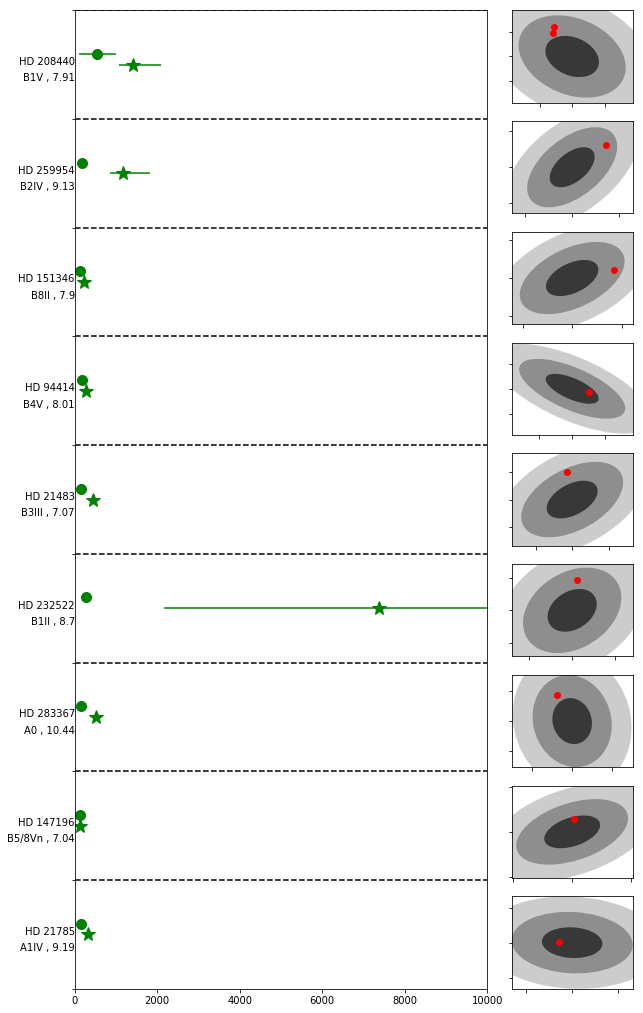

In [17]:
fig2=plt.figure(2,figsize=(10,2*len(behind_results)))

G=gridspec.GridSpec(len(behind_results),4)
subplt=plt.subplot(G[:,0:3])
subplt.set_yticklabels([])
subplt.set_ylim(0,len(behind_results))
subplt.set_xlim(0,10000)
#subplt.set_xlim(0,700)
k=0
for result in behind_results:
    pgcc=result[0]
    sightline=result[1][0][0][2]
    gaia_data=result[1][0][1]
    plx=gaia_data['parallax']
    plx_err=gaia_data['parallax_error']
    
    pgcc_dist=1000.*result[0]['dist']
    pgcc_min_dist=pgcc_dist-1000.*pgcc['dist_sig']
    pgcc_max_dist=pgcc_dist+1000.*pgcc['dist_sig']
    star_dist=1000./(plx)
    star_min_dist=round(1000./(plx+plx_err),3)
    star_max_dist=round(1000./(plx-plx_err),3)
    if star_max_dist < 0.0:
        star_max_dist = 2.*star_dist
    if star_min_dist>pgcc_max_dist:
        col='g'
    elif star_max_dist < pgcc_min_dist:
        col='r'
    else:
        col='k'
    subplt.errorbar(star_dist,k+0.5,xerr=[[star_dist-star_min_dist],[star_max_dist-star_dist]],fmt='*',color=col,ms=15)
    subplt.errorbar(pgcc_dist,k+0.6,xerr=1000.*pgcc['dist_sig'],fmt='o',color=col,ms=10)
    subplt.text(0,k+0.5,sightline,ha='right')
    
    sp=Simbad.SpType(sightline)
    b,v=Simbad.BVFluxes(sightline)
    subplt.text(0,k+0.35,sp+' , '+str(v),ha='right')
    subplt.axhline(k+1,0,1,linestyle='--',color='k')
    
    subplt1=plt.subplot(G[len(behind_results)-1-k,3])
    k=k+1
    
    subplt1.set_xlim(-1.*pgcc['gau_major_axis'],1.*pgcc['gau_major_axis'])
    subplt1.set_ylim(-1.*pgcc['gau_major_axis'],1.*pgcc['gau_major_axis'])
    subplt1.set_xticklabels([])
    subplt1.set_yticklabels([])
    for i in range(1,4):
        ell=Ellipse(xy=(0,0),width=i*pgcc['gau_major_axis'],
                    height=i*pgcc['gau_minor_axis'],angle=-(180./np.pi)*pgcc['gau_position_angle'])
        ell.set_facecolor('k')
        ell.set_alpha(0.6/i)
        subplt1.add_patch(ell)
    
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    
    for dataset in result[1]:
        ra=float(dataset[0][3])
        dec=float(dataset[0][4])
        gal=SkyCoord(ra=ra*u.degree,dec=dec*u.degree,frame='icrs').galactic
        del_l=60.*(gal.l.value-pgcc['glon'])
        del_b=60.*(gal.b.value-pgcc['glat'])
        #if (((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2)<=1.:
        subplt1.plot(del_l,del_b,'ro')
        
    if sightline=='HD 147196':
        print del_l,del_b